# Processing the data from the AIMS eReefs extraction tool - Wind and currents
In this example we use the [AIMS eReefs extraction tool](https://extraction.ereefs.aims.gov.au/) to extract time series data for two locations of interest. 

## Example problem: How strong does the wind need to be to set the direction of the surface ocean currents?
In this example we investigate the relationship between the strength of the wind and the direction of the surface currents for two locations. We will look at Myrmidon Reef, which is on the far outer edge of the GBR and is almost right in the middle of the southern Eastern Australian Current. Our second location will be Davies Reef which is further in the reef matrix, but in a similar sector of the GBR. 

## Analysis method
The East Australian Current (EAC) usually is a strong southward current near Myrmidon and Davies Reefs. During winter months the wind moves in a north eastern direction in the near opposite direction to the EAC. When the wind is low the surface currents are dominated by the EAC. As the wind picks up at some speed the wind overpowers the EAC and the surface current moves in the direction of the wind.

To determine the relation between the wind and the surface currents we will use the AIMS eReefs extraction tool to pull out hourly time series wind and current data for our two locations of interest. We will then use the dot product between the current and wind vectors to create an estimate of how well the vectors are aligned with each other. A positive dot product means both the current and the wind are pointing in the same direction, if the dot product is negative then the wind and currents are pointing in opposite directions. The size of the dot product depends on the strength of the current and the wind. If they are aligned and strong then the dot product will be large.

To look at the relationship we will simply plot the current and wind dot product against the magnitude of the wind.

## Setting up to get the data
To extract the time series data using the extraction tool we need to create a CSV file containing the sites of interest. This file needs to contain the coordinates and names of the sites. To create this I first added my points manually in Google Earth Pro. This was done to simply get the location of Myrmidon and Davies Reefs. Using Google Earth to create your CSV file for the extraction tool is only useful if you don't already know the coordinates of your sites.

![Screenshot of Google Earth Pro with Myromidon and Davies reef sites](media/3-extraction-tool-google-earth-reef-locatons.jpg)

The points can be added using the `Add placemark` tool (looks like a pin). The locations can be seen by displaying the placemark properties. The [resulting KML file](media/3-extraction-tool-locations.kml) can be found in the media directory of this notebook.

The location of the two sites were copied to create the CSV file for the data extraction tool.
```
name,lat,lon
Myrmidon Reef,-18.265599,147.389028
Davies Reef,-18.822840,147.645209
```

## Extracting the data
The [CSV file](media/3-extraction-tool-reef-locations.csv) was uploaded to the [AIMS extraction tool](https://extraction.ereefs.aims.gov.au/) and the extraction was performed with the following settings:
*Data collection:* GBR1 Hydro (Version 2)
*Variables:* Eastward wind speed (wspeed_u), Northward wind speed (wspeed_v), Northward current (v), Eastward current (u)
*Date range:* 1 January 2019 - 31 December 2019
*Time step:* hourly
*Depths:* -2.35 m

Once the extraction request was submitted the dataset was created after an one hour of processing the data was available for download from [Extraction request: Example dataset: Wind-vs-Current at Davies and Myrmidon Reefs (2019)](https://extraction.ereefs.aims.gov.au/data/2009.c451dc3). 

## Downloading the data
In this notebook we will download the data using scripting. There is no need to re-run the extraction request as each extraction performed by the extraction tool has a permanent public page created for it that can be used to facilitate sharing of the data. 

Let's first create a temporary folder to contain the downloaded data. Note: The temp folder is excluded using the .gitignore so it is not saved to the code repository, which is why we must reproduce it.

In [1]:
import os
if not os.path.exists('temp'):
    os.makedirs('temp')

Now let's download the data. The file to download is 12.9 MB and so this download might take a little while. To allow us to re-run this script without having to wait for the download each time we first check that the download has not already been done.

In [2]:
import urllib.request
extractionfile = os.path.join('temp','2009.c451dc3-collected.csv')  # Use os.path.join so the script will work cross-platform

if not os.path.exists(extractionfile):
    print("Downloading extraction data ...")
    url = 'https://api.ereefs.aims.gov.au/data-extraction/request/2009.c451dc3/files/2009.c451dc3-collected.csv'
    req = urllib.request.urlretrieve(url, extractionfile)
    print(req)
else:
    print("Skipping redownloading extraction data")

('temp/2009.c451dc3-collected.csv', <http.client.HTTPMessage object at 0x7f8ef1540550>)


## Reading and cleaning the data
Read the resulting CSV file into a [Pandas data frame](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

In [3]:
import pandas as pd
df = pd.read_csv(extractionfile)
df.head()

,Aggregated Date/Time,Variable,Depth,Site Name,Latitude,Longitude,mean,median,p5,p95,lowest,highest
0,2019-01-01T00:00,wspeed_u,99999.90,Myrmidon Reef,-18.265599,147.389028,-9.568488,-9.568488,-9.568488,-9.568488,-9.568488,-9.568488
1,2019-01-01T00:00,wspeed_u,99999.90,Davies Reef,-18.822840,147.645209,-8.880175,-8.880175,-8.880175,-8.880175,-8.880175,-8.880175
2,2019-01-01T00:00,wspeed_v,99999.90,Myrmidon Reef,-18.265599,147.389028,3.260430,3.260430,3.260430,3.260430,3.260430,3.260430
3,2019-01-01T00:00,wspeed_v,99999.90,Davies Reef,-18.822840,147.645209,2.756750,2.756750,2.756750,2.756750,2.756750,2.756750
4,2019-01-01T00:00,v,-2.35,Myrmidon Reef,-18.265599,147.389028,0.047311,0.047311,0.047311,0.047311,0.047311,0.047311


Here we can see that data is in [tidy format](https://towardsdatascience.com/whats-tidy-data-how-to-organize-messy-datasets-in-python-with-melt-and-pivotable-functions-5d52daa996c9). That is each observation is in one row per time step, variable, depth and site. For each of these combinations there are summary statistics corresponding to the aggregation process that was applied. Somewhat confusingly we extracted hourly data from the hourly eReefs hydrodynamic model and so there was no aggregation applied. As a result all the stats values are the same and the mean corresponds to the actual extracted data values. Let's clean this up a little by removing the redundant columns.

In [4]:
df2 = df.drop(columns=['median', 'p5', 'p95', 'lowest','highest']).rename(columns={"mean": "value"})
df2.head()

,Aggregated Date/Time,Variable,Depth,Site Name,Latitude,Longitude,value
0,2019-01-01T00:00,wspeed_u,99999.90,Myrmidon Reef,-18.265599,147.389028,-9.568488
1,2019-01-01T00:00,wspeed_u,99999.90,Davies Reef,-18.822840,147.645209,-8.880175
2,2019-01-01T00:00,wspeed_v,99999.90,Myrmidon Reef,-18.265599,147.389028,3.260430
3,2019-01-01T00:00,wspeed_v,99999.90,Davies Reef,-18.822840,147.645209,2.756750
4,2019-01-01T00:00,v,-2.35,Myrmidon Reef,-18.265599,147.389028,0.047311


Align the wind and current values for a given time step and site all one row. Here we are converting the data from tall format to wide format. Here we also drop the depth variable as the depth of the wind doesn't match the depth of the surface current. Since we are only processing a single depth this is an OK simplification. If we were processing the current at multiple depths then we would need a more complex set of data wraggling.

In [5]:
df3 = df2.pivot(index = ["Site Name", "Latitude", "Longitude", "Aggregated Date/Time", ], columns="Variable", values="value")
df3.head()

Variable                                                      u         v  \
Site Name   Latitude  Longitude  Aggregated Date/Time                       
Davies Reef -18.82284 147.645209 2019-01-01T00:00     -0.048835  0.100391   
                                 2019-01-01T01:00     -0.090807 -0.036129   
                                 2019-01-01T02:00     -0.118289 -0.180480   
                                 2019-01-01T03:00     -0.110750 -0.278911   
                                 2019-01-01T04:00     -0.079472 -0.312360   

Variable                                               wspeed_u  wspeed_v  
Site Name   Latitude  Longitude  Aggregated Date/Time                      
Davies Reef -18.82284 147.645209 2019-01-01T00:00     -8.880175  2.756750  
                                 2019-01-01T01:00     -8.749271  2.753487  
                                 2019-01-01T02:00     -8.463824  2.587230  
                                 2019-01-01T03:00     -8.223801  2.112059  
                                 2019-01-01T04:00     -8.565171  2.711215

Our aim is to create an index that estimates the correlation of the current and the wind vectors.

The correlation of the current and wind vectors can be estimated based using the [dot product](https://www.mathsisfun.com/algebra/vectors-dot-product.html). An overview of the relationship between correlation and using the dot product is described in [Geometric Interpretation of the Correlation between Two Variables](https://medium.com/@ns2586/geometric-interpretation-of-the-correlation-between-two-variables-4011fb3ea18e). The correlation between the two vectors 'r' is given by:

$r = \cos(\theta) = \frac{a \cdot b}{\|a\| \cdot \|b\|}$

where $a \cdot b$ is the dot product between the tow vectors and $\|a\|$ and $\|b\|$ are the magnitudes of the vectors. The dot product can be calculated using the following.

$a \cdot b = a_{x} \times b_{x} + a_{y} \times b_{y}$

$\|a\| = \sqrt{a_{x}^2+a_{y}^2}$

$\|b\| = \sqrt{b_{x}^2+b_{y}^2}$


In [6]:
import numpy as np
df3['currentmag'] = np.sqrt(df3['u']**2+df3['v']**2)
df3['windmag'] = np.sqrt(df3['wspeed_u']**2+df3['wspeed_v']**2)
df3['windcurrentcorr'] = (df3['u'] * df3['wspeed_u'] + df3['v'] * df3['wspeed_v'])/(df3['currentmag']*df3['windmag'])

# Estimate the dot product without normalisation
df3['windcurrentcorr2'] = (df3['u'] * df3['wspeed_u'] + df3['v'] * df3['wspeed_v'])
df3.head()

Variable                                                      u         v  \
Site Name   Latitude  Longitude  Aggregated Date/Time                       
Davies Reef -18.82284 147.645209 2019-01-01T00:00     -0.048835  0.100391   
                                 2019-01-01T01:00     -0.090807 -0.036129   
                                 2019-01-01T02:00     -0.118289 -0.180480   
                                 2019-01-01T03:00     -0.110750 -0.278911   
                                 2019-01-01T04:00     -0.079472 -0.312360   

Variable                                               wspeed_u  wspeed_v  \
Site Name   Latitude  Longitude  Aggregated Date/Time                       
Davies Reef -18.82284 147.645209 2019-01-01T00:00     -8.880175  2.756750   
                                 2019-01-01T01:00     -8.749271  2.753487   
                                 2019-01-01T02:00     -8.463824  2.587230   
                                 2019-01-01T03:00     -8.223801  2.112059   
                                 2019-01-01T04:00     -8.565171  2.711215   

Variable                                               currentmag   windmag  \
Site Name   Latitude  Longitude  Aggregated Date/Time                         
Davies Reef -18.82284 147.645209 2019-01-01T00:00        0.111638  9.298236   
                                 2019-01-01T01:00        0.097730  9.172319   
                                 2019-01-01T02:00        0.215790  8.850428   
                                 2019-01-01T03:00        0.300094  8.490683   
                                 2019-01-01T04:00        0.322311  8.984033   

Variable                                               windcurrentcorr  \
Site Name   Latitude  Longitude  Aggregated Date/Time                    
Davies Reef -18.82284 147.645209 2019-01-01T00:00             0.684380   
                                 2019-01-01T01:00             0.775325   
                                 2019-01-01T02:00             0.279727   
                                 2019-01-01T03:00             0.126259   
                                 2019-01-01T04:00            -0.057391   

Variable                                               windcurrentcorr2  
Site Name   Latitude  Longitude  Aggregated Date/Time                    
Davies Reef -18.82284 147.645209 2019-01-01T00:00              0.710413  
                                 2019-01-01T01:00              0.695011  
                                 2019-01-01T02:00              0.534230  
                                 2019-01-01T03:00              0.321708  
                                 2019-01-01T04:00             -0.166183

Let's look at the relationship between the wind and current as a function of the wind speed. Here we are considering each hourly sample as an independent estimate of the relationship. In reality this is not the case as the longer the wind blows the more effect it will have on the current. As this is just a coding example and not an in-depth analysis we don't need to worry about this limitation of the analysis.

Let's pull out the data for Davies and Myrmidon Reefs separately so they are easy to plot.

In [7]:
davies = df3.query('`Site Name` == "Davies Reef"')
myrmidon = df3.query('`Site Name` == "Myrmidon Reef"')
myrmidon.head()

Variable                                                         u         v  \
Site Name     Latitude   Longitude  Aggregated Date/Time                       
Myrmidon Reef -18.265599 147.389028 2019-01-01T00:00      0.012498  0.047311   
                                    2019-01-01T01:00     -0.029212 -0.013297   
                                    2019-01-01T02:00     -0.060520 -0.066542   
                                    2019-01-01T03:00     -0.078321 -0.111699   
                                    2019-01-01T04:00     -0.076759 -0.132760   

Variable                                                  wspeed_u  wspeed_v  \
Site Name     Latitude   Longitude  Aggregated Date/Time                       
Myrmidon Reef -18.265599 147.389028 2019-01-01T00:00     -9.568488  3.260430   
                                    2019-01-01T01:00     -9.420339  3.528335   
                                    2019-01-01T02:00     -9.333500  3.765564   
                                    2019-01-01T03:00     -9.281394  3.784521   
                                    2019-01-01T04:00     -8.527690  3.885759   

Variable                                                  currentmag  \
Site Name     Latitude   Longitude  Aggregated Date/Time               
Myrmidon Reef -18.265599 147.389028 2019-01-01T00:00        0.048934   
                                    2019-01-01T01:00        0.032096   
                                    2019-01-01T02:00        0.089947   
                                    2019-01-01T03:00        0.136421   
                                    2019-01-01T04:00        0.153353   

Variable                                                    windmag  \
Site Name     Latitude   Longitude  Aggregated Date/Time              
Myrmidon Reef -18.265599 147.389028 2019-01-01T00:00      10.108727   
                                    2019-01-01T01:00      10.059420   
                                    2019-01-01T02:00      10.064477   
                                    2019-01-01T03:00      10.023316   
                                    2019-01-01T04:00       9.371266   

Variable                                                  windcurrentcorr  \
Site Name     Latitude   Longitude  Aggregated Date/Time                    
Myrmidon Reef -18.265599 147.389028 2019-01-01T00:00             0.070078   
                                    2019-01-01T01:00             0.707019   
                                    2019-01-01T02:00             0.347188   
                                    2019-01-01T03:00             0.222466   
                                    2019-01-01T04:00             0.096513   

Variable                                                  windcurrentcorr2  
Site Name     Latitude   Longitude  Aggregated Date/Time                    
Myrmidon Reef -18.265599 147.389028 2019-01-01T00:00              0.034665  
                                    2019-01-01T01:00              0.228272  
                                    2019-01-01T02:00              0.314299  
                                    2019-01-01T03:00              0.304198  
                                    2019-01-01T04:00              0.138700

Let's create a scatter plot to see if there is a relationship between the wind and currents.

Text(0.5, 1.0, 'Correlation between wind and surface current (hourly data, 2019)')

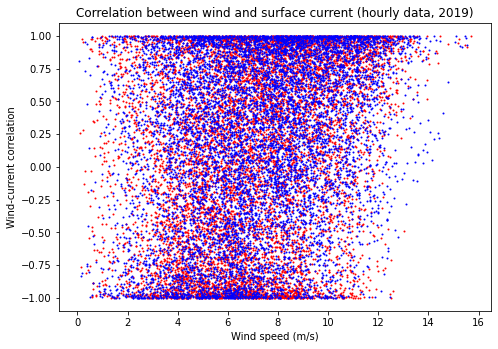

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(myrmidon["windmag"],myrmidon["windcurrentcorr"], color='r', s=1)
ax.scatter(davies["windmag"],davies["windcurrentcorr"], color='b', s=1)
ax.set_xlabel('Wind speed (m/s)')
ax.set_ylabel('Wind-current correlation')
ax.set_title('Correlation between wind and surface current (hourly data, 2019)')

This scatter plot shows that the relationship between wind and current is weak. This is no surprising given that we are considering just the hourly samples, with no consideration for how long the wind has been blowing. At low wind conditions the current has an even chance of being aligned with the wind (correlation = 1) as in the opposite direction (correlation = -1), however in high wind we can see that there is much more chance that the currents are aligned with the wind.

To understand this relationship better we want to understand how much the wind nudges the current in its direction. If we bin the wind speeds then collect all the correlation samples in each bin then we can see if they average to zero (indicating that there is no relationship between the wind and current) or there is average alignment. 

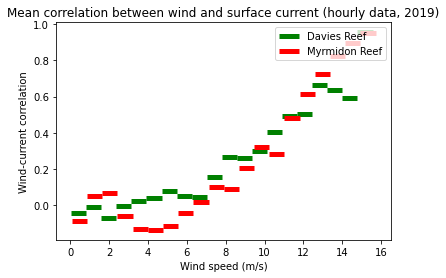

In [9]:
from scipy import stats
wind = davies["windmag"]
current = davies["windcurrentcorr"]
bin_means, bin_edges, binnumber = stats.binned_statistic(wind, current, 'mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,
           label='Davies Reef')

wind = myrmidon["windmag"]
current = myrmidon["windcurrentcorr"]
bin_means, bin_edges, binnumber = stats.binned_statistic(wind, current, 'mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='Myrmidon Reef')

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Wind-current correlation')
plt.title('Mean correlation between wind and surface current (hourly data, 2019)')
plt.legend()

From this we can see that for wind speeds below 8 m/s the surface current direction is unrelated to the wind. Above this wind speed the surface current is increasingly determined by the direction of the wind. By the time the wind is 16 m/s the direction of the surface current is dominated by the wind direction.

Note: It should be remembered that this analysis is based on the eReefs Hydrodynamic model and as such is not based on real data. The eReefs model has however been tuned to accurately capture the flow dynamics of the GBR and so we would expect the estimates from this analysis to be approximately correct.